# Importing and manipulating data with Pandas
An initial analysis of AirBnB listings in Brussels.

In [1]:
# this cell contains our library imports
import pandas as pd
import altair as alt
import geopandas as geopandas

alt.data_transformers.disable_max_rows()
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

In [2]:
data = pd.read_csv('listings_brussels_20190813.csv')

## Clean up the data a bit and calculate occupancy information

In [3]:
data = data.query('price < 600') # entries over 600 euro are likely typos or hosts that misunderstood the platform
data = data.query('reviews_per_month > 0 & last_review > "2018-07-31"') # we remove any listings with zero reviews for now to focus only on 'active' listings

In [4]:
def calculate_occupancy_rate(number_of_reviews, minimum_nights):
    # first we set some additional assumptions
    review_rate = 0.5
    days_in_month = 31
    average_stay_length_assumption = 3
    max_occupancy = 0.7

    # calculate occupancy
    average_stay_length = minimum_nights.clip(lower = average_stay_length_assumption)
    occupancy_per_month = number_of_reviews / review_rate * average_stay_length / days_in_month
    
    # cap occupancy at max_occupancy
    exceed_max_occupancy = occupancy_per_month > max_occupancy
    
    occupancy_per_month.loc[exceed_max_occupancy] = 0.7

    # fill missing values with a zero (0)
    occupancy_per_month_fillna = occupancy_per_month.fillna(0)

    return occupancy_per_month_fillna

In [5]:
data['occupancy_rate'] = calculate_occupancy_rate(data['reviews_per_month'], data['minimum_nights'])
data['monthly_rental_income'] =  data['price'] * data['occupancy_rate'] * 31

## Ready to roll

In [6]:
data

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,occupancy_rate,monthly_rental_income
0,2352,"Triplex-2chmbrs,grande sdb,terrasse= tous confort",2582,Oda,Molenbeek-Saint-Jean,50.85787,4.30809,Entire home/apt,93,2,15,2018-12-31,0.23,229,0.044516,128.34
1,2354,COURT/Long- 1chmb+1salon+sdd+terras,2582,Oda,Molenbeek-Saint-Jean,50.85697,4.30651,Entire home/apt,78,2,2,2018-10-28,0.05,340,0.009677,23.40
2,42521,Ixelles: spacious bedroom+boudoir+ensuite bath...,185699,Claire,Ixelles,50.81929,4.38790,Private room,45,2,130,2019-07-28,1.19,283,0.230323,321.30
3,45145,B&B Welcome to my place - 2,199370,Erick,Saint-Josse-ten-Noode,50.85300,4.36971,Private room,70,2,3,2019-04-08,0.03,190,0.005806,12.60
5,52796,Bright apartment in Ixelles/Louise,244722,Pierre,Ixelles,50.83356,4.36027,Entire home/apt,74,5,96,2019-07-20,0.93,326,0.300000,688.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8830,37472109,La guarida de Cinquantenaire,282690578,Antonio,Bruxelles,50.84451,4.39488,Entire home/apt,40,1,1,2019-08-07,1.00,2,0.193548,240.00
8839,37490590,Appartement 75m² lumineux & cosy - Saint Antoine,26375325,Pierre,Etterbeek,50.83065,4.38724,Entire home/apt,65,2,1,2019-08-11,1.00,56,0.193548,390.00
8849,37522158,appartement sympathique dans le quartier d'Ixe...,190430531,Pierre,Ixelles,50.82105,4.38667,Private room,28,1,1,2019-08-07,1.00,69,0.193548,168.00
8864,37561594,Bright apartment in the historical center.,283734248,Max,Bruxelles,50.84614,4.35407,Entire home/apt,70,2,1,2019-08-10,1.00,122,0.193548,420.00


In [7]:
districts = geopandas.read_file('URBIS_ADM_MD/UrbAdm_MONITORING_DISTRICT.shp')

In [8]:
districts

,ID,VERSIONID,MDRC,NAME_FRE,NAME_DUT,NAME_BIL,AREA,INSPIRE_ID,BEGIN_LIFE,END_LIFE,geometry
0,83,1,83,CONSCIENCE,CONSCIENCE,CONSCIENCE,469489.90,BE.BRUSSELS.BRIC.ADM.MD.53,2015-10-05,None,"POLYGON ((151836.566 173466.414, 151866.597 17..."
1,80,1,80,HELMET,HELMET,HELMET,718634.24,BE.BRUSSELS.BRIC.ADM.MD.54,2015-10-05,None,"POLYGON ((150764.790 173563.033, 150805.931 17..."
2,19,1,19,VIEUX LAEKEN OUEST,OUD LAKEN WEST,OUD LAKEN WEST / VIEUX LAEKEN OUEST,499645.52,BE.BRUSSELS.BRIC.ADM.MD.123,2015-10-05,None,"POLYGON ((147858.070 174004.707, 147866.788 17..."
3,20,1,20,VIEUX LAEKEN EST,OUD LAKEN OOST,OUD LAKEN OOST / VIEUX LAEKEN EST,1040449.92,BE.BRUSSELS.BRIC.ADM.MD.66,2015-10-05,None,"POLYGON ((148132.120 173445.561, 148132.121 17..."
4,800,1,800,INDUSTRIE NORD,INDUSTRIE NOORD,INDUSTRIE NOORD / NORD,6733601.22,BE.BRUSSELS.BRIC.ADM.MD.70,2018-01-02,None,"POLYGON ((151113.691 177049.939, 151114.596 17..."
...,...,...,...,...,...,...,...,...,...,...,...
140,97,1,97,PUTDAAL,PUTDAAL,PUTDAAL,781853.24,BE.BRUSSELS.BRIC.ADM.MD.87,2015-10-05,None,"POLYGON ((154365.007 167360.572, 154371.960 16..."
141,92,1,92,KAPELLEVELD,KAPELLEVELD,KAPELLEVELD,1918208.26,BE.BRUSSELS.BRIC.ADM.MD.107,2018-01-02,None,"POLYGON ((155443.251 171738.671, 155442.192 17..."
142,96,1,96,SAINT-PAUL,SINT-PAULUS,ST-PAUL(US),1782749.86,BE.BRUSSELS.BRIC.ADM.MD.38,2015-10-05,None,"POLYGON ((154884.558 169524.678, 154884.633 16..."
143,94,1,94,STOCKEL,STOKKEL,STOKKEL / STOCKEL,1516750.55,BE.BRUSSELS.BRIC.ADM.MD.135,2018-01-02,None,"POLYGON ((156936.652 170326.070, 156932.309 17..."


In [9]:
districts['AREA'].agg('mean')
districts.query('NAME_FRE == NAME_DUT').size

572

<AxesSubplot:>

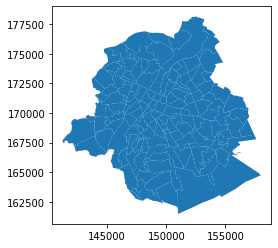

In [10]:
districts.plot()

In [19]:
data_geo = geopandas.GeoDataFrame(data, geometry = geopandas.points_from_xy(data['longitude'], data['latitude']), crs = 'EPSG:4326')

<AxesSubplot:>

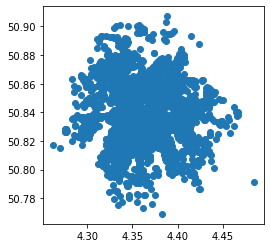

In [20]:
data_geo.plot()

In [21]:
geopandas.sjoin(districts, data_geo)

,ID,VERSIONID,MDRC,NAME_FRE,NAME_DUT,NAME_BIL,AREA,INSPIRE_ID,BEGIN_LIFE,END_LIFE,...,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,availability_365,occupancy_rate,monthly_rental_income


In [22]:
districts.crs

<Projected CRS: EPSG:31370>
Name: Belge 1972 / Belgian Lambert 72
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: Belgium - onshore
- bounds: (2.5, 49.5, 6.4, 51.51)
Coordinate Operation:
- name: Belgian Lambert 72
- method: Lambert Conic Conformal (2SP)
Datum: Reseau National Belge 1972
- Ellipsoid: International 1924
- Prime Meridian: Greenwich

In [23]:
data_geo.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [26]:
districts = districts.to_crs(data_geo.crs)

In [41]:
data_geo_district = geopandas.sjoin(data_geo, districts)

In [39]:
data_geo_district

,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,...,ID,VERSIONID,MDRC,NAME_FRE,NAME_DUT,NAME_BIL,AREA,INSPIRE_ID,BEGIN_LIFE,END_LIFE
0,2352,"Triplex-2chmbrs,grande sdb,terrasse= tous confort",2582,Oda,Molenbeek-Saint-Jean,50.85787,4.30809,Entire home/apt,93,2,...,65,1,65,KORENBEEK,KORENBEEK,KORENBEEK,761638.30,BE.BRUSSELS.BRIC.ADM.MD.129,2018-01-02,None
1,2354,COURT/Long- 1chmb+1salon+sdd+terras,2582,Oda,Molenbeek-Saint-Jean,50.85697,4.30651,Entire home/apt,78,2,...,65,1,65,KORENBEEK,KORENBEEK,KORENBEEK,761638.30,BE.BRUSSELS.BRIC.ADM.MD.129,2018-01-02,None
741,4782792,Loft with lots of light and terrace,24659375,Bruno,Berchem-Sainte-Agathe,50.85865,4.30133,Entire home/apt,77,3,...,65,1,65,KORENBEEK,KORENBEEK,KORENBEEK,761638.30,BE.BRUSSELS.BRIC.ADM.MD.129,2018-01-02,None
4564,21824142,Chambre à couchée chaleureuse et confortable,85494248,Farida Et Cris,Berchem-Sainte-Agathe,50.86082,4.30312,Private room,40,1,...,65,1,65,KORENBEEK,KORENBEEK,KORENBEEK,761638.30,BE.BRUSSELS.BRIC.ADM.MD.129,2018-01-02,None
5012,23662827,Appartement moderne avec ascenseur,85494248,Farida Et Cris,Molenbeek-Saint-Jean,50.85649,4.30587,Entire home/apt,74,2,...,65,1,65,KORENBEEK,KORENBEEK,KORENBEEK,761638.30,BE.BRUSSELS.BRIC.ADM.MD.129,2018-01-02,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6760,31251016,Résidence la floraison 4,113781053,Neerpede,Anderlecht,50.82632,4.27610,Private room,86,1,...,55,1,55,NEERPEDE,NEERPEDE,NEERPEDE,3960597.57,BE.BRUSSELS.BRIC.ADM.MD.111,2018-01-02,None
8590,36830342,Luxury Penthouse in Brussels !,276817136,Georgio,Anderlecht,50.81734,4.26193,Entire home/apt,64,1,...,55,1,55,NEERPEDE,NEERPEDE,NEERPEDE,3960597.57,BE.BRUSSELS.BRIC.ADM.MD.111,2018-01-02,None
7007,32238503,La suite de la Princesse,241917919,Bianca Elena,Anderlecht,50.84498,4.29771,Private room,80,1,...,60,1,60,BUFFON,BUFFON,BUFFON,463037.40,BE.BRUSSELS.BRIC.ADM.MD.23,2015-10-05,None
7008,32242817,La suite du Roi,241917919,Bianca Elena,Anderlecht,50.84401,4.29638,Private room,150,1,...,60,1,60,BUFFON,BUFFON,BUFFON,463037.40,BE.BRUSSELS.BRIC.ADM.MD.23,2015-10-05,None


In [45]:
stats_per_district = data_geo_district.groupby('ID')['monthly_rental_income'].agg(['count', 'mean', 'sum']).reset_index()

In [46]:
stats_per_district

,ID,count,mean,sum
0,1,349,1208.085272,421621.76
1,2,275,1106.220291,304210.58
2,3,139,1107.254532,153908.38
3,4,76,1058.994474,80483.58
4,5,81,1181.606914,95710.16
...,...,...,...,...
131,911,2,2317.170000,4634.34
132,913,3,647.133333,1941.40
133,914,2,362.400000,724.80
134,915,6,536.346667,3218.08


In [51]:
districts_stats = districts.merge(stats_per_district, on = 'ID')

In [52]:
districts_stats

,ID,VERSIONID,MDRC,NAME_FRE,NAME_DUT,NAME_BIL,AREA,INSPIRE_ID,BEGIN_LIFE,END_LIFE,geometry,count,mean,sum
0,83,1,83,CONSCIENCE,CONSCIENCE,CONSCIENCE,469489.90,BE.BRUSSELS.BRIC.ADM.MD.53,2015-10-05,None,"POLYGON ((4.39484 50.87157, 4.39527 50.87168, ...",7,611.991429,4283.94
1,80,1,80,HELMET,HELMET,HELMET,718634.24,BE.BRUSSELS.BRIC.ADM.MD.54,2015-10-05,None,"POLYGON ((4.37962 50.87244, 4.38020 50.87259, ...",19,411.884211,7825.80
2,19,1,19,VIEUX LAEKEN OUEST,OUD LAKEN WEST,OUD LAKEN WEST / VIEUX LAEKEN OUEST,499645.52,BE.BRUSSELS.BRIC.ADM.MD.123,2015-10-05,None,"POLYGON ((4.33832 50.87641, 4.33844 50.87643, ...",11,595.698182,6552.68
3,20,1,20,VIEUX LAEKEN EST,OUD LAKEN OOST,OUD LAKEN OOST / VIEUX LAEKEN EST,1040449.92,BE.BRUSSELS.BRIC.ADM.MD.66,2015-10-05,None,"POLYGON ((4.34222 50.87138, 4.34222 50.87138, ...",38,598.270526,22734.28
4,800,1,800,INDUSTRIE NORD,INDUSTRIE NOORD,INDUSTRIE NOORD / NORD,6733601.22,BE.BRUSSELS.BRIC.ADM.MD.70,2018-01-02,None,"POLYGON ((4.38459 50.90379, 4.38460 50.90380, ...",2,355.600000,711.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,97,1,97,PUTDAAL,PUTDAAL,PUTDAAL,781853.24,BE.BRUSSELS.BRIC.ADM.MD.87,2015-10-05,None,"POLYGON ((4.43069 50.81667, 4.43079 50.81676, ...",3,346.980000,1040.94
132,92,1,92,KAPELLEVELD,KAPELLEVELD,KAPELLEVELD,1918208.26,BE.BRUSSELS.BRIC.ADM.MD.107,2018-01-02,None,"POLYGON ((4.44606 50.85602, 4.44604 50.85597, ...",5,723.560000,3617.80
133,96,1,96,SAINT-PAUL,SINT-PAULUS,ST-PAUL(US),1782749.86,BE.BRUSSELS.BRIC.ADM.MD.38,2015-10-05,None,"POLYGON ((4.43809 50.83612, 4.43809 50.83618, ...",10,302.946000,3029.46
134,94,1,94,STOCKEL,STOKKEL,STOKKEL / STOCKEL,1516750.55,BE.BRUSSELS.BRIC.ADM.MD.135,2018-01-02,None,"POLYGON ((4.46724 50.84330, 4.46718 50.84275, ...",5,618.320000,3091.60


<AxesSubplot:>

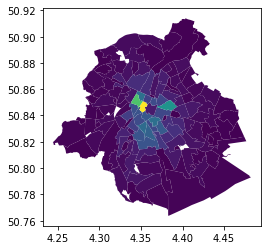

In [56]:
districts_stats.plot(column = 'sum')